# Import libraries and yamnet model

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

yamnet_model_url = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_url)
def extract_embedding(wav_data):
    #run YAMNet to extract embedding from the wav dat
    _, embeddings, _ = yamnet_model(wav_data)
    return embeddings.numpy()



In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Define pad functions

In [3]:
def pad_mfccs(mfccs, max_len):
    if max_len > mfccs.shape[1]:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [4]:
def pad_yam_embeddings(e, max_len):
    if max_len > e.shape[0]:
        pad_width = max_len - e.shape[0]
        e = np.pad(e, pad_width=((0, pad_width), (0, 0)), mode='constant')
    return e

# Load data and extract features:
* mfccs
* yamnet embeddings
* logmel spectrogram

### Split data into train and test set, keeping proportions of the unbalanced classes

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
path = './data'
mfccs = []
yamnet_embeddings = []
logmel = []
labels = []
max_len_mfcc = 0
max_len_yam = 0
max_logmel = 0
for dir, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(dir, file)
        label = dir.split(os.path.sep)[1]
        if file.endswith(".wav"):
            audio, sample_rate = librosa.load(file_path,sr = 16000)
            
            # yamnet embeddings
            yam_emb = extract_embedding(audio)
            yamnet_embeddings.append(yam_emb)
            # logmel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
            logmel.append(log_mel_spectrogram)
            # mfcc
            mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, sr=sample_rate, n_mfcc=20)
            mfccs.append(mfcc)
            # max dimensions for padding
            max_logmel = max(max_logmel, log_mel_spectrogram.shape[1])
            max_len_mfcc = max(max_len_mfcc, mfcc.shape[1])
            max_len_yam = max(max_len_yam, yam_emb.shape[0])
            labels.append(label)
mfccs_padded = [pad_mfccs(mfcc, max_len_mfcc) for mfcc in mfccs]
yamnet_embeddings_padded = [pad_yam_embeddings(e,max_len_yam) for e in yamnet_embeddings]
# reuse pad_mfccs function for logmel, since the dimension to be padded is the same
logmel_padded = [pad_mfccs(l, max_logmel) for l in logmel]
yam_x = np.array(yamnet_embeddings_padded)
mfcc_x = np.array(mfccs_padded)
logmel_x = np.array(logmel_padded)
y = np.array(labels)
scaler = MinMaxScaler()
# minmax scale mfcc and logmel
mfcc_x = scaler.fit_transform(mfcc_x.reshape(mfcc_x.shape[0], -1)).reshape(mfcc_x.shape)
logmel_x = scaler.fit_transform(logmel_x.reshape(logmel_x.shape[0], -1)).reshape(logmel_x.shape)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Split the dataset into training and testing sets, maintaining class proportions
mfcc_x_train, mfcc_x_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
yam_x_train, yam_x_test, yam_y_train, yam_y_test = train_test_split(yam_x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
logmel_x_train, logmel_x_test, logmel_y_train, logmel_y_test = train_test_split(logmel_x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [111]:
mfcc_x.shape, logmel_x.shape, yam_x.shape

((6512, 20, 75), (6512, 128, 75), (6512, 4, 1024))

# K-Means clustering on every feature

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
def kmeans(features,plot_title):
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(features)

# Apply PCA to reduce dimensionality for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(features)

    # Visualize the feature space using k-means clusters
    plt.figure(figsize=(8, 6))
    for cluster in range(10):
        indices = np.where(kmeans.labels_ == cluster)
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Cluster {cluster}', alpha=0.5)

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=100, c='red', label='Cluster Centers')

    plt.title(plot_title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

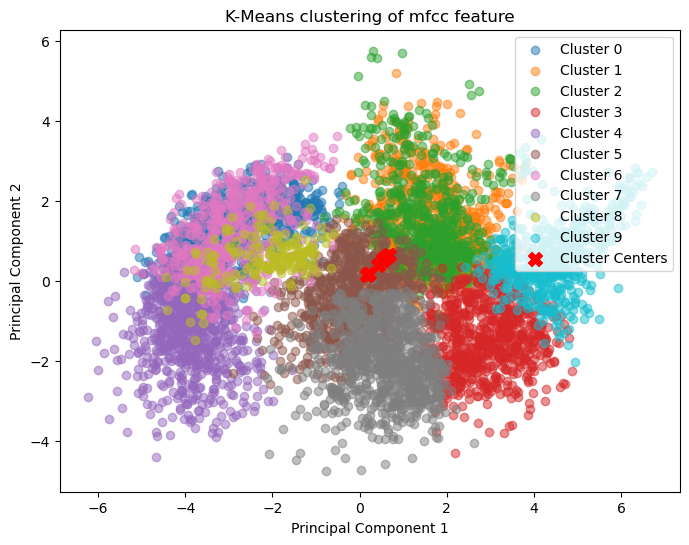

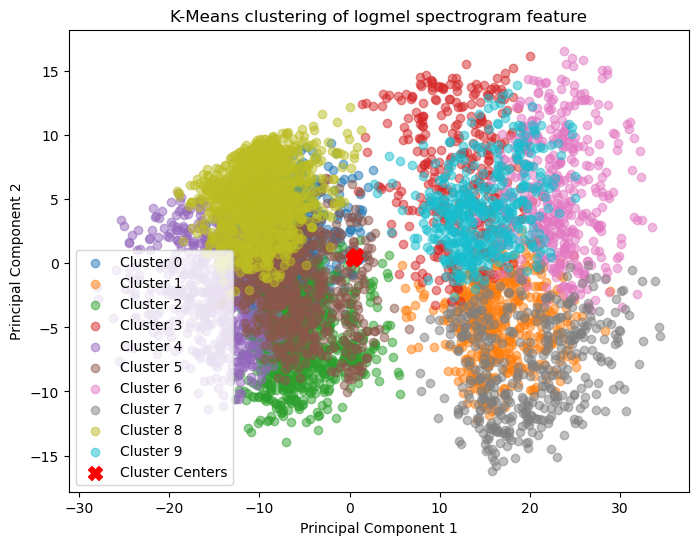

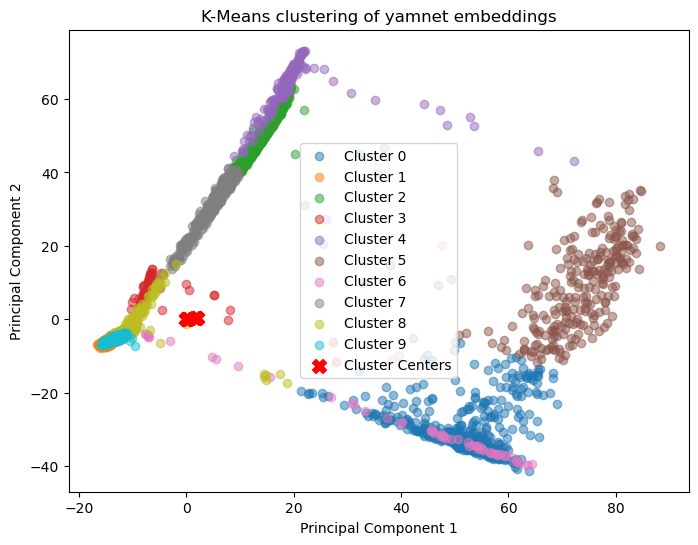

In [43]:
kmeans(mfcc_x.reshape(mfcc_x.shape[0],-1),'K-Means clustering of mfcc feature')
kmeans(logmel_x.reshape(logmel_x.shape[0],-1),'K-Means clustering of logmel spectrogram feature')
kmeans(yam_x.reshape(yam_x.shape[0],-1),'K-Means clustering of yamnet embeddings')

# Random forest using each feature

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
def random_forest(x_train,y_train,x_test,y_test,used_feature):
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)

    # Make predictions
    y_pred = rf_classifier.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))

    print(f"Input: {used_feature}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [149]:
random_forest(mfcc_x_train.reshape(mfcc_x_train.shape[0],-1),mfcc_y_train,mfcc_x_test.reshape(mfcc_x_test.shape[0],-1),mfcc_y_test,'MFCC')

Input: MFCC
Accuracy: 0.56
Classification Report:
              precision    recall  f1-score   support

        .223       0.59      0.35      0.44        69
       .22LR       0.71      0.96      0.81       273
       .308W       0.53      0.60      0.57        68
        .357       0.96      0.33      0.49        69
        .380       0.80      0.06      0.11        69
      .38SPL       0.90      0.13      0.23        67
         .40       0.49      0.59      0.54       208
         .45       0.45      0.60      0.51       208
     7.62x39       0.64      0.21      0.32        66
         9mm       0.46      0.51      0.48       206

    accuracy                           0.56      1303
   macro avg       0.65      0.43      0.45      1303
weighted avg       0.60      0.56      0.53      1303



In [112]:
random_forest(logmel_x_train.reshape(logmel_x_train.shape[0],-1),logmel_y_train,logmel_x_test.reshape(logmel_x_test.shape[0],-1),logmel_y_test,'logmel spectrogram')

Input: logmel spectrogram
Accuracy: 0.54
Classification Report:
              precision    recall  f1-score   support

        .223       0.67      0.29      0.40        69
       .22LR       0.79      0.95      0.86       273
       .308W       0.54      0.54      0.54        68
        .357       0.69      0.35      0.46        69
        .380       0.88      0.10      0.18        69
      .38SPL       0.75      0.18      0.29        67
         .40       0.45      0.59      0.51       208
         .45       0.41      0.57      0.47       208
     7.62x39       0.60      0.27      0.38        66
         9mm       0.39      0.42      0.40       206

    accuracy                           0.54      1303
   macro avg       0.61      0.43      0.45      1303
weighted avg       0.58      0.54      0.52      1303



In [113]:
random_forest(yam_x_train.reshape(yam_x_train.shape[0],-1),yam_y_train,yam_x_test.reshape(yam_x_test.shape[0],-1),yam_y_test,'yamnet embeddings')

Input: yamnet embeddings
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

        .223       0.56      0.42      0.48        69
       .22LR       0.69      0.90      0.78       273
       .308W       0.40      0.28      0.33        68
        .357       0.36      0.06      0.10        69
        .380       0.50      0.03      0.05        69
      .38SPL       0.50      0.01      0.03        67
         .40       0.37      0.41      0.39       208
         .45       0.32      0.52      0.39       208
     7.62x39       0.62      0.23      0.33        66
         9mm       0.33      0.37      0.35       206

    accuracy                           0.45      1303
   macro avg       0.46      0.32      0.32      1303
weighted avg       0.46      0.45      0.41      1303



# KNN using each feature

In [114]:
from sklearn.neighbors import KNeighborsClassifier
def knn(x_train,y_train,x_test,y_test,used_feature):
    knn_classifier = KNeighborsClassifier(n_neighbors=10)
    knn_classifier.fit(x_train, y_train)

    # Make predictions
    y_pred = knn_classifier.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))
    print(f"Input: {used_feature}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [115]:
knn(mfcc_x_train.reshape(mfcc_x_train.shape[0],-1),mfcc_y_train,mfcc_x_test.reshape(mfcc_x_test.shape[0],-1),mfcc_y_test,'MFCC')

Input: MFCC
Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

        .223       0.45      0.36      0.40        69
       .22LR       0.78      0.94      0.85       273
       .308W       0.56      0.69      0.62        68
        .357       0.46      0.45      0.46        69
        .380       0.24      0.25      0.24        69
      .38SPL       0.56      0.15      0.24        67
         .40       0.46      0.54      0.50       208
         .45       0.43      0.50      0.46       208
     7.62x39       0.60      0.18      0.28        66
         9mm       0.41      0.35      0.38       206

    accuracy                           0.53      1303
   macro avg       0.49      0.44      0.44      1303
weighted avg       0.52      0.53      0.51      1303



In [116]:
knn(logmel_x_train.reshape(logmel_x_train.shape[0],-1),logmel_y_train,logmel_x_test.reshape(logmel_x_test.shape[0],-1),logmel_y_test,'logmel spectrogram')

Input: logmel spectrogram
Accuracy: 0.34
Classification Report:
              precision    recall  f1-score   support

        .223       0.17      0.17      0.17        69
       .22LR       0.74      0.76      0.75       273
       .308W       0.28      0.28      0.28        68
        .357       0.22      0.14      0.17        69
        .380       0.04      0.03      0.04        69
      .38SPL       0.00      0.00      0.00        67
         .40       0.27      0.38      0.31       208
         .45       0.24      0.34      0.28       208
     7.62x39       0.11      0.02      0.03        66
         9mm       0.25      0.21      0.23       206

    accuracy                           0.34      1303
   macro avg       0.23      0.23      0.23      1303
weighted avg       0.32      0.34      0.32      1303



In [117]:
knn(yam_x_train.reshape(yam_x_train.shape[0],-1),yam_y_train,yam_x_test.reshape(yam_x_test.shape[0],-1),yam_y_test,'yamnet embeddings')

Input: yamnet embeddings
Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

        .223       0.43      0.29      0.34        69
       .22LR       0.69      0.89      0.78       273
       .308W       0.34      0.40      0.37        68
        .357       0.36      0.35      0.35        69
        .380       0.22      0.12      0.15        69
      .38SPL       0.38      0.13      0.20        67
         .40       0.31      0.39      0.35       208
         .45       0.28      0.35      0.31       208
     7.62x39       0.42      0.15      0.22        66
         9mm       0.30      0.22      0.25       206

    accuracy                           0.42      1303
   macro avg       0.37      0.33      0.33      1303
weighted avg       0.40      0.42      0.39      1303



# Fully connected feed forward NN with yamnet embeddings as input

In [54]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Flatten(input_shape=yam_x_train.shape[1:]),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            restore_best_weights=True)
model.fit(yam_x_train, yam_y_train, epochs=100, validation_data=(yam_x_test, yam_y_test),callbacks=callback)




Epoch 1/100
163/163 [==============================] - 2s 6ms/step - loss: 1.9689 - accuracy: 0.3596 - val_loss: 1.5640 - val_accuracy: 0.4060
Epoch 2/100
163/163 [==============================] - 1s 5ms/step - loss: 1.4909 - accuracy: 0.4454 - val_loss: 1.4666 - val_accuracy: 0.4421
Epoch 3/100
163/163 [==============================] - 1s 5ms/step - loss: 1.3531 - accuracy: 0.4857 - val_loss: 1.4415 - val_accuracy: 0.4298
Epoch 4/100
163/163 [==============================] - 1s 5ms/step - loss: 1.2502 - accuracy: 0.5181 - val_loss: 1.3679 - val_accuracy: 0.4728
Epoch 5/100
163/163 [==============================] - 1s 5ms/step - loss: 1.1573 - accuracy: 0.5504 - val_loss: 1.3312 - val_accuracy: 0.5012
Epoch 6/100
163/163 [==============================] - 1s 5ms/step - loss: 1.0750 - accuracy: 0.5849 - val_loss: 1.3850 - val_accuracy: 0.4820
Epoch 7/100
163/163 [==============================] - 1s 5ms/step - loss: 1.0096 - accuracy: 0.6082 - val_loss: 1.3094 - val_accuracy: 0.4919

In [150]:
y_pred_probabilities = model.predict(yam_x_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
accuracy = accuracy_score(mfcc_y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


# CNN 2D convolution with logmel as input

In [36]:

logmel_conv2d = models.Sequential([
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=np.expand_dims(logmel_x_train,-1).shape[1:]),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

logmel_conv2d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
logmel_history = logmel_conv2d.fit(np.expand_dims(logmel_x_train,-1), logmel_y_train, epochs=100, validation_data=(np.expand_dims(logmel_x_test,-1), logmel_y_test),callbacks=callback)

Epoch 1/100
163/163 [==============================] - 8s 47ms/step - loss: 2.9842 - accuracy: 0.2488 - val_loss: 2.0007 - val_accuracy: 0.2939
Epoch 2/100
163/163 [==============================] - 7s 43ms/step - loss: 1.8427 - accuracy: 0.3360 - val_loss: 1.8001 - val_accuracy: 0.3484
Epoch 3/100
163/163 [==============================] - 7s 44ms/step - loss: 1.6675 - accuracy: 0.3863 - val_loss: 1.6776 - val_accuracy: 0.3607
Epoch 4/100
163/163 [==============================] - 7s 41ms/step - loss: 1.4852 - accuracy: 0.4360 - val_loss: 1.5232 - val_accuracy: 0.4428
Epoch 5/100
163/163 [==============================] - 7s 41ms/step - loss: 1.3554 - accuracy: 0.4786 - val_loss: 1.4512 - val_accuracy: 0.4459
Epoch 6/100
163/163 [==============================] - 7s 41ms/step - loss: 1.2443 - accuracy: 0.5162 - val_loss: 1.3683 - val_accuracy: 0.4781
Epoch 7/100
163/163 [==============================] - 7s 41ms/step - loss: 1.1291 - accuracy: 0.5679 - val_loss: 1.2362 - val_accuracy:

In [151]:
y_pred_probabilities = logmel_conv2d.predict(np.expand_dims(logmel_x_test,-1))
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
accuracy = accuracy_score(mfcc_y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.68


# CNN 2D convolution wtih MFCCs as input

In [57]:
mfcc_conv2d = models.Sequential([
        layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=np.expand_dims(mfcc_x_train,-1).shape[1:]),
        layers.MaxPooling2D(pool_size=(2,3)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

mfcc_conv2d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mfcc_history_2d = mfcc_conv2d.fit(np.expand_dims(mfcc_x_train,-1), mfcc_y_train, epochs=110, validation_data=(np.expand_dims(mfcc_x_test,-1), mfcc_y_test),callbacks=callback)

Epoch 1/110
163/163 [==============================] - 5s 31ms/step - loss: 1.8910 - accuracy: 0.3296 - val_loss: 1.4680 - val_accuracy: 0.4643
Epoch 2/110
163/163 [==============================] - 2s 12ms/step - loss: 1.1697 - accuracy: 0.5623 - val_loss: 1.0184 - val_accuracy: 0.6209
Epoch 3/110
163/163 [==============================] - 2s 11ms/step - loss: 0.8607 - accuracy: 0.6848 - val_loss: 0.8849 - val_accuracy: 0.6516
Epoch 4/110
163/163 [==============================] - 2s 11ms/step - loss: 0.6994 - accuracy: 0.7387 - val_loss: 0.8419 - val_accuracy: 0.6876
Epoch 5/110
163/163 [==============================] - 2s 11ms/step - loss: 0.6024 - accuracy: 0.7798 - val_loss: 0.7419 - val_accuracy: 0.7183
Epoch 6/110
163/163 [==============================] - 2s 11ms/step - loss: 0.5236 - accuracy: 0.8167 - val_loss: 0.7381 - val_accuracy: 0.7137
Epoch 7/110
163/163 [==============================] - 2s 11ms/step - loss: 0.4511 - accuracy: 0.8368 - val_loss: 0.7740 - val_accuracy:

In [152]:
y_pred_probabilities = mfcc_conv2d.predict(np.expand_dims(mfcc_x_test,-1))
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
accuracy = accuracy_score(mfcc_y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.75


# CNN 1D convolution with MFCC as input

In [131]:
mfcc_conv1d = models.Sequential([
        layers.Conv1D(128, kernel_size=(3), activation='relu', input_shape=(mfcc_x_train).shape[1:]),
        layers.MaxPooling1D(pool_size=(2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

mfcc_conv1d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mfcc_history_1d = mfcc_conv1d.fit((mfcc_x_train), mfcc_y_train, epochs=100, validation_data=((mfcc_x_test), mfcc_y_test),callbacks=callback)
y_pred_probabilities = mfcc_conv1d.predict((mfcc_x_test))
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Evaluate the model
accuracy = accuracy_score(mfcc_y_test, y_pred_classes)
report = classification_report(label_encoder.inverse_transform(mfcc_y_test), label_encoder.inverse_transform(y_pred_classes))

Epoch 1/100
163/163 [==============================] - 2s 8ms/step - loss: 1.8165 - accuracy: 0.3463 - val_loss: 1.4550 - val_accuracy: 0.4413
Epoch 2/100
163/163 [==============================] - 1s 7ms/step - loss: 1.2320 - accuracy: 0.5322 - val_loss: 1.1202 - val_accuracy: 0.5480
Epoch 3/100
163/163 [==============================] - 1s 7ms/step - loss: 1.0329 - accuracy: 0.6011 - val_loss: 1.0053 - val_accuracy: 0.6147
Epoch 4/100
163/163 [==============================] - 1s 6ms/step - loss: 0.9328 - accuracy: 0.6381 - val_loss: 0.8916 - val_accuracy: 0.6516
Epoch 5/100
163/163 [==============================] - 1s 6ms/step - loss: 0.8523 - accuracy: 0.6763 - val_loss: 0.8595 - val_accuracy: 0.6470
Epoch 6/100
163/163 [==============================] - 1s 6ms/step - loss: 0.8224 - accuracy: 0.6907 - val_loss: 0.7732 - val_accuracy: 0.6946
Epoch 7/100
163/163 [==============================] - 1s 6ms/step - loss: 0.7706 - accuracy: 0.7086 - val_loss: 0.8050 - val_accuracy: 0.6746

In [129]:
mfcc_conv1d.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 18, 128)           28928     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 9, 128)           0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 9, 128)            0         
                                                                 
 flatten_29 (Flatten)        (None, 1152)              0         
                                                                 
 dense_58 (Dense)            (None, 512)               590336    
                                                                 
 dense_59 (Dense)            (None, 10)                5130      
                                                     

# Results

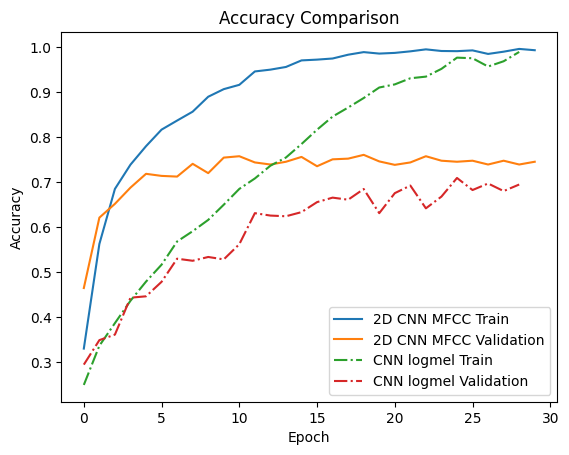

In [120]:
plt.plot(mfcc_history_2d.history['accuracy'], label='2D CNN MFCC Train')
plt.plot(mfcc_history_2d.history['val_accuracy'], label='2D CNN MFCC Validation')
plt.plot(logmel_history.history['accuracy'], label='CNN logmel Train',linestyle='-.')
plt.plot(logmel_history.history['val_accuracy'], label='CNN logmel Validation',linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.show()

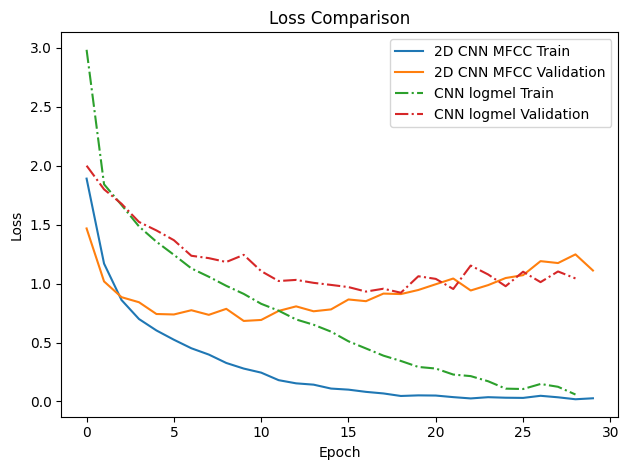

In [122]:
plt.plot(mfcc_history_2d.history['loss'], label='2D CNN MFCC Train')
plt.plot(mfcc_history_2d.history['val_loss'], label='2D CNN MFCC Validation')
plt.plot(logmel_history.history['loss'], label='CNN logmel Train',linestyle='-.')
plt.plot(logmel_history.history['val_loss'], label='CNN logmel Validation',linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.tight_layout()
plt.show()

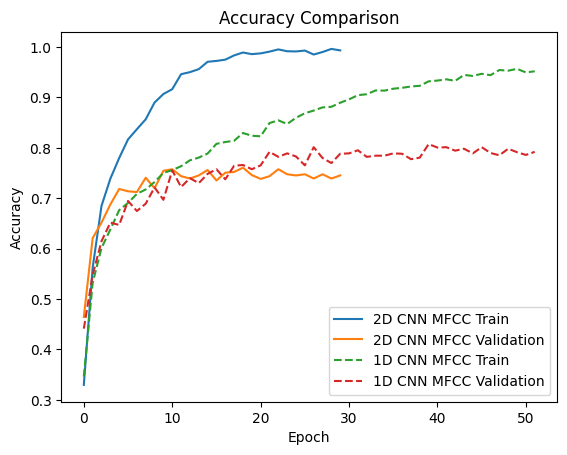

In [135]:
plt.plot(mfcc_history_2d.history['accuracy'], label='2D CNN MFCC Train')
plt.plot(mfcc_history_2d.history['val_accuracy'], label='2D CNN MFCC Validation')
plt.plot(mfcc_history_1d.history['accuracy'], label='1D CNN MFCC Train',linestyle='--')
plt.plot(mfcc_history_1d.history['val_accuracy'], label='1D CNN MFCC Validation',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

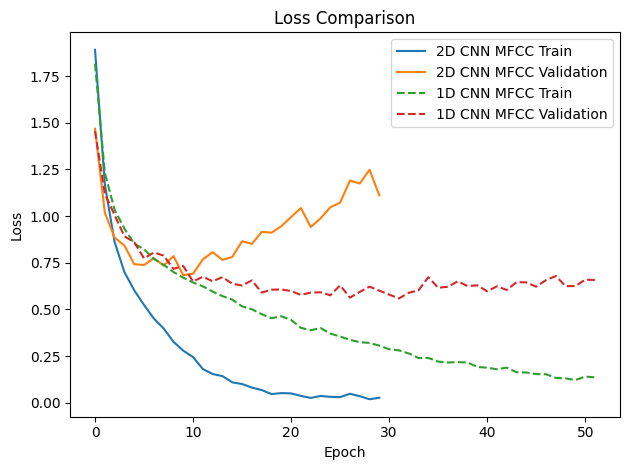

In [136]:
plt.plot(mfcc_history_2d.history['loss'], label='2D CNN MFCC Train')
plt.plot(mfcc_history_2d.history['val_loss'], label='2D CNN MFCC Validation')
plt.plot(mfcc_history_1d.history['loss'], label='1D CNN MFCC Train',linestyle='--')
plt.plot(mfcc_history_1d.history['val_loss'], label='1D CNN MFCC Validation',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [137]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

        .223       0.93      0.77      0.84        69
       .22LR       0.96      0.93      0.94       273
       .308W       0.72      0.97      0.82        68
        .357       0.91      0.88      0.90        69
        .380       0.72      0.45      0.55        69
      .38SPL       0.93      0.84      0.88        67
         .40       0.73      0.73      0.73       208
         .45       0.76      0.74      0.75       208
     7.62x39       0.91      0.79      0.85        66
         9mm       0.63      0.76      0.69       206

    accuracy                           0.80      1303
   macro avg       0.82      0.79      0.80      1303
weighted avg       0.80      0.80      0.80      1303



In [138]:
report = classification_report(label_encoder.inverse_transform(mfcc_y_test), label_encoder.inverse_transform(y_pred_classes),output_dict=True)
df = pd.DataFrame(report).transpose()
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
.223 & 0.93 & 0.77 & 0.84 & 69.00 \\
.22LR & 0.96 & 0.93 & 0.94 & 273.00 \\
.308W & 0.72 & 0.97 & 0.82 & 68.00 \\
.357 & 0.91 & 0.88 & 0.90 & 69.00 \\
.380 & 0.72 & 0.45 & 0.55 & 69.00 \\
.38SPL & 0.93 & 0.84 & 0.88 & 67.00 \\
.40 & 0.73 & 0.73 & 0.73 & 208.00 \\
.45 & 0.76 & 0.74 & 0.75 & 208.00 \\
7.62x39 & 0.91 & 0.79 & 0.85 & 66.00 \\
9mm & 0.63 & 0.76 & 0.69 & 206.00 \\
accuracy & 0.80 & 0.80 & 0.80 & 0.80 \\
macro avg & 0.82 & 0.79 & 0.80 & 1303.00 \\
weighted avg & 0.80 & 0.80 & 0.80 & 1303.00 \\
\bottomrule
\end{tabular}



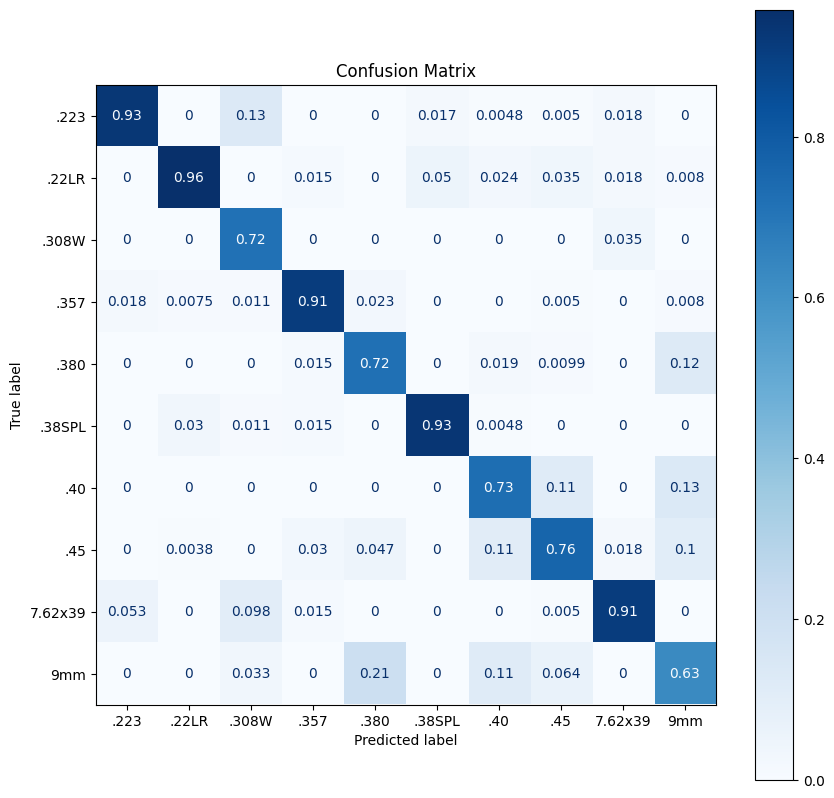

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(label_encoder.inverse_transform(mfcc_y_test), label_encoder.inverse_transform(y_pred_classes) , normalize='pred')
classes = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
# Plot the confusion matrix

disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix')
plt.show()